In [71]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
import os
import math
import time

import tensorflow as tf
import datetime



In [72]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [93]:
# Hyperparameters
nbEpochs = 3
train_batch_size = 100
test_batch_size = 100
dropoutChance = 0.5
lossControlPenalty = 0.7 # controlPenalty = 0.4...0.7
source = "SVHN"
target = "MNIST"
sourceChannels = 1
dataPath = os.path.dirname(os.getcwd()) + "/data/"
log_dir = os.path.dirname(os.getcwd()) + "/logs/" + "{}-{}, ".format(source, target) +"{} epochs, ".format(nbEpochs) + datetime.datetime.now().strftime("Date - %Y%m%d-%H%M")
randomSeed = 1905
print(dataPath)

/home/pmirallesr/Documents/DRCN-Torch/data/


In [94]:
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

**TEXT**

In [95]:
class GaussianDenoising:
    """Distort a pixel with additive [+ N(0,scale)] or multiplicative [x N(1,scale)] gaussian noise"""

    def __init__(self, sigma = 0.2, effectType = "additive"):
        self.sigma = sigma
        self.effectType = effectType

    def __call__(self, x):
        if effectType == "multiplicative":
            return x.numpy() * np.random.normal(loc = 1.0, scale = sigma, size = x.shape)
        elif effectType == "additive":
            return x.numpy + np.random.normal(loc = 0.0, scale = sigma, size = x.shape)
        else:
            print("Specify a valid type of gaussian error: multiplicative or additive")
            raise ValueError

In [96]:
class ImpulseDenoising:
    """Erase a pixel with probability p"""

    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, x):
        return x.numpy() * np.random.binomial(1, self.p, size=x.shape)

In [97]:
# Data Transforms
# Normalizations commented as torch already imports normalized data on 32x32

# Data Augmentation - Geometric Transformations
# 20º random rotation
# 20% random height and width shifts
dataAugmentTransforms = []
dataAugmentTransforms.append(torchvision.transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2)))
# Denoising
dataAugmentTransforms.append(torchvision.transforms.ToTensor())
dataAugmentTransforms.append(ImpulseDenoising())


MNIST_Transforms = []
MNIST_Transforms.append(torchvision.transforms.Resize((32,32), interpolation = 2)) #Rescale to SVHN size
#MNIST_Transforms.append(torchvision.transforms.Resize((32,32)))
# MNIST_Mean = 0.1307
# MNIST_StDev = 0.3081
# MNIST_Transforms.append(torchvision.transforms.Normalize(MNIST_Mean, MNIST_StDev))



SVHN_Transforms = []
SVHN_Transforms.append(torchvision.transforms.Grayscale())
# SVHN_Mean = 0.4657
# SVHN_StDev = 0.2025
# SVHN_Transforms.append(torchvision.transforms.Normalize(SVHN_Mean, SVHN_StDev))

In [98]:
train_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = True, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms + dataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_MNIST_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.MNIST(dataPath, \
                train = False, download = True, \
                transform = torchvision.transforms.Compose\
                (MNIST_Transforms + [torchvision.transforms.ToTensor()])), batch_size = test_batch_size, shuffle = True)

#DataLoader has irregular behaviour, does not autom create an SVHN folder but does so for MNIST
train_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "train", download = True, \
                transform = torchvision.transforms.Compose\
                (SVHN_Transforms + dataAugmentTransforms)), batch_size = train_batch_size, shuffle = True)

test_SVHN_loader = torch.utils.data.DataLoader \
                (torchvision.datasets.SVHN(dataPath + "SVHN/", \
                split = "test", download = True , \
                 transform = torchvision.transforms.Compose \
                (SVHN_Transforms + [torchvision.transforms.ToTensor()])), batch_size = test_batch_size, shuffle = True)


Using downloaded and verified file: /home/pmirallesr/Documents/DRCN-Torch/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/pmirallesr/Documents/DRCN-Torch/data/SVHN/test_32x32.mat


In [99]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = [16,9]    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Source Domain batch


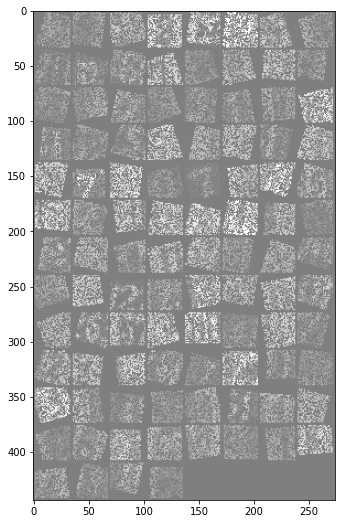

Target Domain batch


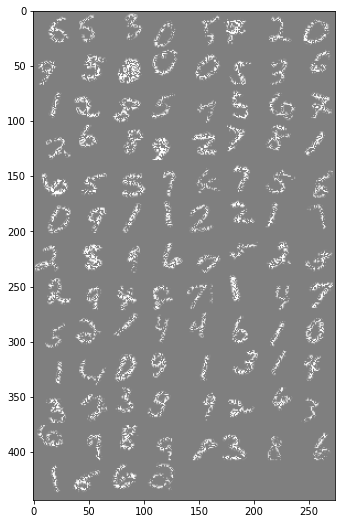

In [100]:
# get some random training images from source
batch_id, (images, labels) = next(enumerate(train_SVHN_loader))

print('Source Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
batch_id, (images, labels) = next(enumerate(train_MNIST_loader))

print('Target Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

In [101]:
def calcConvOutputDimensions(inputDim, kernelSize, padding = (0,0), dilation = (1,1), stride = (1,1)):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, kernelSize, padding, dilation, stride]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    Hout = math.floor((variables[0][0] + 2*variables[2][0] - variables[3][0]*(variables[1][0] - 1) -1)/variables[4][0] + 1)
    Wout = math.floor((variables[0][1] + 2*variables[2][1] - variables[3][1]*(variables[1][1] - 1) -1)/variables[4][1] + 1)
    return (Hout, Wout)

def calcPoolOutputDimensions(inputDim, pooling):
    """ Calculates the output dimensions from a convolutional layer with the given parameters """
    variables = [inputDim, pooling]
    for i, elem in enumerate(variables):
        if isinstance(elem, int):
            variables[i] = (elem, elem)
        elif isinstance(elem, tuple):
            pass
        else:
            raise ValueError
    if len(inputDim) != len(pooling):
        raise ValueError
    return tuple(int(inputDim[i]/pooling[i]) for i,ti in enumerate(pooling) )
    

In [102]:
# Models
class Encoder(nn.Module):
    """Encoder common to Autoencoder and labeller"""

    def __init__(self, inputChannels, dropoutChance = 0.5):
        """Initialize DomainRegressor."""
        super(Encoder, self).__init__()
        
        #Size Parameters
        
        conv1Filters = 100
        conv1KernelSize = 5
        
        maxPool1Size = (2,2)
        
        conv2Filters = 150
        conv2KernelSize = 5
        
        maxPool2Size = (2,2)
        
        conv3Filters = 200
        conv3KernelSize = 3
        
        # Placeholder ranges
#         fc4OutputSize = range(300,1000,50)
#         fc5OutputSize = range(300,1000,50)
        fc4OutputDim = 300
        fc5OutputDim = 300
        
        
        # Convolutional Layers Size Calculations
        conv1InputChannels = inputChannels
        conv2InputChannels = conv1Filters
        conv3InputChannels = conv2Filters
                
        # Convolutional Layers
        self.conv1 = nn.Conv2d(conv1InputChannels, conv1Filters, conv1KernelSize)
        self.maxPool2D1 = nn.MaxPool2d(maxPool1Size)
        self.conv2 = nn.Conv2d(conv2InputChannels, conv2Filters, conv2KernelSize)
        self.maxPool2D2 = nn.MaxPool2d(maxPool2Size)
        self.conv3 = nn.Conv2d(conv3InputChannels, conv3Filters, conv3KernelSize)
        
        # Fully Connected Layers Size Calculations
        conv1OutputDim = calcConvOutputDimensions(32, conv1KernelSize) #Size of SVHN images!
        conv2InputDim = calcPoolOutputDimensions(conv1OutputDim, maxPool1Size)
        conv2OutputDim = calcConvOutputDimensions(conv2InputDim, conv2KernelSize)
        conv3InputDim = calcPoolOutputDimensions(conv2OutputDim, maxPool2Size)
        self.conv3OutputDim = calcConvOutputDimensions(conv3InputDim, conv3KernelSize) # Needed to reconstruct the image in the decoder
        fc4InputDim = conv3Filters*self.conv3OutputDim[0]*self.conv3OutputDim[1]
        fc5InputDim = fc4OutputDim
        
        # Fully connected Layers
        self.fc4 = nn.Linear(fc4InputDim, fc4OutputDim)
        self.dropout4 = nn.Dropout(p = dropoutChance)
        
        self.fc5 = nn.Linear(fc5InputDim, fc5OutputDim)
        self.dropout5 = nn.Dropout(p = dropoutChance)
        
        

    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        # print("Convo1")
        # print(x.shape)
        x = F.relu(self.conv1(x.float()))
        # print(x.shape)
        x = self.maxPool2D1(x)
        # print(x.shape)
        
        # print("Convo2")
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = self.maxPool2D2(x)
        # print(x.shape)
        
        # print("Convo3")
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = x.reshape(x.size(0), -1)
        # print(x.shape)

        # print("Linear")
        x = F.relu(self.fc4(x))
        # print(x.shape)
        x = self.dropout4(x)
        # print(x.shape)
        x = F.relu(self.fc5(x))
        # print(x.shape)
        x = self.dropout5(x)
        # print(x.shape)
        return x

In [103]:
class Labeller(nn.Module):
    """ The labeller part of the network is constituted by 
    the common Encoder plus a labelling fully connected layer"""
    def __init__(self, encoder):
        super(Labeller, self).__init__()
        self.encoder = encoder
        fc3OutputSize = 10 # for 10 possible digits
        fc3InputSize = self.encoder.fc5.out_features
        self.fcOUT = nn.Linear(fc3InputSize, fc3OutputSize)  
        
    def forward(self, x):
        x = self.encoder(x)
        return F.relu(self.fcOUT(x))

    

In [104]:
class Autoencoder(nn.Module):
    """The autoencoder is constituted by the Encoder common to
    the labeller and itself, and a decoder part that is a mirror
    image of the Encoder
    
    Layers 6 and 7 are FC layers, layers 8 through 10 are (de)convolutional layers
    
    """

    def __init__(self, encoder):
        """Initialize DomainRegressor."""
        super(Autoencoder, self).__init__()
        
        self.encoder = encoder
        
        
        # Size Calculations
        fc6OutputSize = self.encoder.fc5.in_features
        fc6InputSize = self.encoder.fc5.out_features
        fc7OutputSize = self.encoder.fc4.in_features
        fc7InputSize = self.encoder.fc4.out_features

        deconv8OutputChannels = self.encoder.conv3.in_channels
        deconv8InputChannels = self.encoder.conv3.out_channels
        deconv8KernelSize = self.encoder.conv3.kernel_size
        upscale8Size = self.encoder.maxPool2D2.kernel_size

        deconv9OutputChannels = self.encoder.conv2.in_channels
        deconv9InputChannels = self.encoder.conv2.out_channels
        deconv9KernelSize = self.encoder.conv2.kernel_size
        upscale9Size = self.encoder.maxPool2D1.kernel_size

        deconv10OutputChannels = self.encoder.conv1.in_channels
        deconv10InputChannels = self.encoder.conv1.out_channels
        deconv10KernelSize = self.encoder.conv1.kernel_size
        
        #Is calcPoolSize still valid for Unspooling?
        
#         deconv9OutputSize = calcPoolOutputSize(deconv8OutputSize,maxPool8Size)
        
#         deconv10OutputSize = calcPoolOutputSize(deconv9OutputSize,maxPool9Size)
        
        
        
        # Layers
        
        self.fc7 = nn.Linear(fc7InputSize, fc7OutputSize)
        self.fc6 = nn.Linear(fc6InputSize, fc6OutputSize)
        
        self.deconv8 = nn.ConvTranspose2d(deconv8InputChannels, deconv8OutputChannels, deconv8KernelSize)
        self.upsample8 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv9 = nn.ConvTranspose2d(deconv9InputChannels, deconv9OutputChannels, deconv9KernelSize)
        self.upsample9 = nn.Upsample(scale_factor = 2, mode = "nearest")
        self.deconv10 = nn.ConvTranspose2d(deconv10InputChannels, deconv10OutputChannels, deconv10KernelSize)
        
        


    def forward(self, x):
        """Forward pass X and return probabilities of source and domain."""
        # print("Encoder")
        x = self.encoder(x)
        
        # print("Linear")
        x = F.relu(self.fc6(x))
        # print(x.shape)
        x = F.relu(self.fc7(x))
        # print(x.shape)

        x = torch.reshape(x, (x.shape[0], self.deconv8.in_channels, self.encoder.conv3OutputDim[0], self.encoder.conv3OutputDim[1]))
        # print(x.shape)
        
        # print("Deconv 8")
        x = F.relu(self.deconv8(x))
        # print(x.shape)
        x = F.relu(self.upsample8(x))
        # print(x.shape)
        
        # print("Deconv 9")
        x = F.relu(self.deconv9(x))
        # print(x.shape)
        x = F.relu(self.upsample8(x))
        # print(x.shape)
        
        # print("Final deconv")
        x = self.deconv10(x)
        # print(x.shape)
        
       
        return x

In [105]:
encoder = Encoder(sourceChannels).to(device)
labeller = Labeller(encoder).to(device)
autoencoder = Autoencoder(encoder).to(device)

In [106]:
optimizer = torch.optim.RMSprop(list(labeller.parameters()) + list(autoencoder.parameters()), lr=1e-4, alpha=0.99, eps=1e-07, weight_decay=0.9, momentum=0, centered=False)

In [112]:
encoder.train()
labeller.train()
print("Training for {} epochs".format(nbEpochs))
avgEpochTime = 0
start = time.time()
batchesVerbosity = 1
batches2Process = 3
SVHNBatches = int(73300/train_batch_size) #SVHN size
MNISTBatches = int(60000/train_batch_size) #MNIST size
train_summary_writer = tf.summary.create_file_writer(log_dir)
for epoch in range(1, nbEpochs + 1):
    epochStart = time.time()
    for batch_id, (data, target) in enumerate(train_SVHN_loader):
        data = data.to(device)
        target = target.to(device)
        forward = labeller(data)
        labellerLoss = nn.CrossEntropyLoss()
        labellerLoss = lossControlPenalty * labellerLoss(forward, target)
        lossClone = labellerLoss.detach().cpu()
        with train_summary_writer.as_default():
            index = epoch*SVHNBatches + batch_id
            tf.summary.scalar('Labeller Loss', lossClone, index)
        if(batch_id%batchesVerbosity == 0):
          print("Source batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, lossClone))
          if(batch_id == batches2Process):
                break
        optimizer.zero_grad()
        labellerLoss.backward()
        optimizer.step()
        
    for batch_id, (data, target) in enumerate(train_MNIST_loader):
        data = data.to(device)
        target = target.to(device)
        forward = autoencoder(data)
        data = torch.tensor(data, dtype = torch.double, requires_grad=True).to(device)
        autoencoderLoss = nn.MSELoss()
        autoencoderLoss = (1 - lossControlPenalty) * autoencoderLoss(forward, data)
        lossClone = autoencoderLoss.detach().cpu()
        with train_summary_writer.as_default():
            index = epoch*MNISTBatches + batch_id
            tf.summary.scalar('Autoencoder_Loss', lossClone, index)
        if(batch_id%batchesVerbosity == 0):
          print("Target batch {}, epoch {}. Loss = {:.5f}".format(batch_id, epoch, lossClone))
          if(batch_id == batches2Process):
                break
        optimizer.zero_grad()
        autoencoderLoss.backward()
        optimizer.step()
        
    epochEnd = time.time()
    avgEpochTime = (avgEpochTime*(epoch-1) + (epochEnd - epochStart)) / epoch
    print("--------------")
    print("Epoch {}/{} completed in {:.5f} minutes".format(epoch, nbEpochs, (epochEnd - epochStart)/60))
    print("{:.3f} minutes elapsed".format((epochEnd - start)/60))
    print("{:.2f} minutes remaining".format(avgEpochTime/60 * (nbEpochs - epoch)))
    print("--------------")
    

Training for 3 epochs
Source batch 0, epoch 1. Loss = 1.61315
Source batch 1, epoch 1. Loss = 1.61384
Source batch 2, epoch 1. Loss = 1.61256
Source batch 3, epoch 1. Loss = 1.61152


<ipython-input-112-664d1fe3e87e>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype = torch.double, requires_grad=True).to(device)


Target batch 0, epoch 1. Loss = 0.02811
Target batch 1, epoch 1. Loss = 0.02171
Target batch 2, epoch 1. Loss = 0.02165
Target batch 3, epoch 1. Loss = 0.01956
--------------
Epoch 1/3 completed in 0.05641 minutes
0.056 minutes elapsed
0.11 minutes remaining
--------------
Source batch 0, epoch 2. Loss = 1.61252
Source batch 1, epoch 2. Loss = 1.61232
Source batch 2, epoch 2. Loss = 1.61317
Source batch 3, epoch 2. Loss = 1.61448
Target batch 0, epoch 2. Loss = 0.02551
Target batch 1, epoch 2. Loss = 0.01949
Target batch 2, epoch 2. Loss = 0.01831
Target batch 3, epoch 2. Loss = 0.01923
--------------
Epoch 2/3 completed in 0.05783 minutes
0.114 minutes elapsed
0.06 minutes remaining
--------------
Source batch 0, epoch 3. Loss = 1.61227
Source batch 1, epoch 3. Loss = 1.61243
Source batch 2, epoch 3. Loss = 1.61250
Source batch 3, epoch 3. Loss = 1.61336
Target batch 0, epoch 3. Loss = 0.02107
Target batch 1, epoch 3. Loss = 0.01861
Target batch 2, epoch 3. Loss = 0.01701
Target batch